In [1]:
import os
import numpy as np

from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras import layers, callbacks

from keras.models import load_model
from sklearn.metrics import multilabel_confusion_matrix

import matplotlib.pyplot as plt

from tqdm import tqdm, tqdm_notebook

In [2]:
# 제스처 좌표데이터셋 목록 읽어오기
file_list = os.listdir("./Dataset")
# 파일 확장자 빼고 제스처 이름만 저장
actions = []
for i in range(len(file_list)) :
    actions.append(file_list[i][:-4])


# 회전변환 행렬
def Rx(theta) :
    return np.array([[1,        0,              0      ], 
                    [ 0,  np.cos(theta), -np.sin(theta)], 
                    [ 0,  np.sin(theta),  np.cos(theta)]])
def Ry(theta) :
    return np.array([[np.cos(theta),  0,  np.sin(theta)], 
                    [       0,        1,        0      ],
                    [-np.sin(theta),  0,  np.cos(theta)]])
def Rz(theta) :
    return np.array([[np.cos(theta), -np.sin(theta),  0  ], 
                    [ np.sin(theta),  np.cos(theta),  0  ], 
                    [       0,              0,        1  ]])
# 각 축을 기준으로 회전변환할 각도 (x, y, z 축 기준 회전각 : pitch, yaw, roll)
rotation_degree_x = np.deg2rad([0, 10,20,30,40]) # 50,60,70,80,90,100,110,120,130, 355,350,340
rotation_degree_y = np.deg2rad([0, 10,20,30,40]) # 50,60,70,80,90,100,110,120,130, 355,350,340
rotation_degree_z = np.deg2rad([0,30,60,90])     # 120,150,180,210,240,270,300,330


# 시퀀스 길이
seq_length = 15

In [3]:
data_X = np.zeros((1, seq_length, 27))    # 25는 angle데이터 길이
data_Y = np.zeros(1)

# 각 제스처 좌표 데이터셋마다
for action_index, action_name in tqdm(enumerate(actions)):
    loaded = np.load(f'./Dataset/{actions[action_index]}.npy')
    # 각 회전마다
    for rdz in rotation_degree_z :
        for rdy in rotation_degree_y :
            for rdx in rotation_degree_x :
                
                data_list_X, data_list_y = [], []
                angle_data = []
                
                # 제스처데이터 각 프레임마다
                for fr in range(len(loaded)) :
                    coord = []
                    
                    # 각 프레임의 모든 랜드마크 좌표 회전변환
                    for lm in range(21) :    
                        coord.append( loaded[fr][lm] @ Rz(rdz) @ Ry(rdy) @ Rx(rdx) )
                    coord = np.array(coord)

                    a = coord[[ 5,  1,2,3,  5,6,7,   9,10,11,  13,14,15,  17,18,19,  0, 0], :]
                    b = coord[[17,  2,3,4,  6,7,8,  10,11,12,  14,15,16,  18,19,20,  5,17], :]
                    vec = b - a
                    vec_unit = vec / np.linalg.norm(vec, axis=1)[:, np.newaxis]
                    vec_unit = np.append(vec_unit, [[1,0,0]], axis=0)
                    vec_unit = np.append(vec_unit, [[0,1,0]], axis=0)
                    vec_unit = np.append(vec_unit, [[0,0,1]], axis=0)
                    
                    angle = np.arccos( np.einsum('ij, ij->i',
                        vec_unit[[0,1,2,  0,4,5,  0,7,8,   0,10,11,   0,13,14,  3,6,9,12,15,  6,9,12,15,   0, 0, 0], :],   # , 0, 0, 0
                        vec_unit[[1,2,3,  4,5,6,  7,8,9,  10,11,12,  13,14,15,  0,0,0, 0, 0,  2,2, 2, 2,  18,19,20], :]))  # ,18,19,20
                    angle = np.degrees(angle)
                    angle_data.append(angle)
                
                # 시퀀스길이에 따라 시퀀스데이터로 변환
                for i in range(len(angle_data) - seq_length):
                    data_list_X.append(angle_data[i: i + seq_length])
                    data_list_y.append(action_index)

                # 문제지, 정답지
                data_X = np.append(data_X, data_list_X, axis=0)
                data_Y = np.append(data_Y, data_list_y, axis=0)

4it [00:04,  1.24s/it]


In [4]:
X = data_X[1:]
Y = data_Y[1:]

In [5]:
Y = to_categorical(Y, num_classes=len(actions))

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [7]:
model = Sequential([
    layers.GRU(24, input_shape = X_train.shape[1:], activation='tanh'),
    # layers.Dense(24, activation='relu'),
    layers.Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 24)                3816      
                                                                 
 dense (Dense)               (None, 4)                 100       
                                                                 
Total params: 3,916
Trainable params: 3,916
Non-trainable params: 0
_________________________________________________________________


In [8]:
epochs = 15
checkpoint = callbacks.ModelCheckpoint('./Models/model.h5', monitor='val_loss', save_best_only=True)
earlystopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

hist = model.fit(   X_train, Y_train,
                    validation_split=0.25,
                    epochs = epochs,
                    callbacks = [checkpoint, earlystopping],
                    verbose=1   )

Epoch 1/15
51/51 [==============================] - 2s 11ms/step - loss: 1.2541 - accuracy: 0.3951 - val_loss: 0.8768 - val_accuracy: 0.5407
Epoch 2/15
51/51 [==============================] - 0s 4ms/step - loss: 0.7377 - accuracy: 0.7451 - val_loss: 0.6002 - val_accuracy: 0.9759
Epoch 3/15
51/51 [==============================] - 0s 4ms/step - loss: 0.5244 - accuracy: 0.9951 - val_loss: 0.4422 - val_accuracy: 1.0000
Epoch 4/15
51/51 [==============================] - 0s 5ms/step - loss: 0.4085 - accuracy: 1.0000 - val_loss: 0.3608 - val_accuracy: 1.0000
Epoch 5/15
51/51 [==============================] - 0s 4ms/step - loss: 0.3335 - accuracy: 1.0000 - val_loss: 0.2978 - val_accuracy: 1.0000
Epoch 6/15
51/51 [==============================] - 0s 5ms/step - loss: 0.2804 - accuracy: 1.0000 - val_loss: 0.2511 - val_accuracy: 1.0000
Epoch 7/15
51/51 [==============================] - 0s 4ms/step - loss: 0.2323 - accuracy: 1.0000 - val_loss: 0.1971 - val_accuracy: 1.0000
Epoch 8/15
51/51 [=

In [9]:
score = model.evaluate(X_test, Y_test)

17/17 [==============================] - 0s 1ms/step - loss: 0.0549 - accuracy: 1.0000


### 학습 그래프

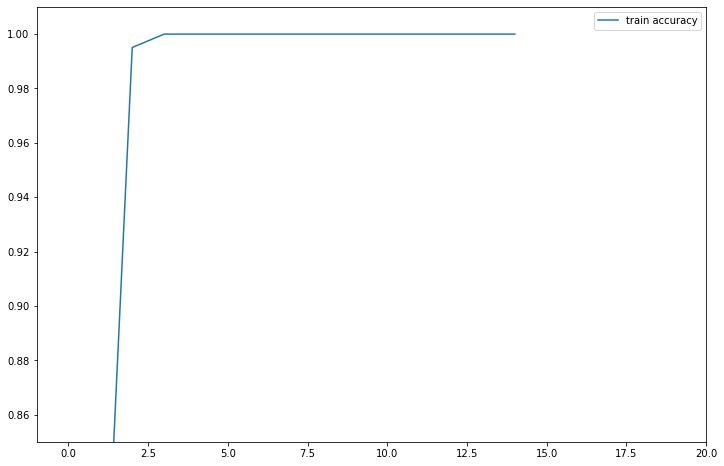

In [10]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['accuracy'], label='train accuracy')

plt.xlim(-1,20)
plt.ylim(0.85,1.01)

plt.legend(), plt.grid
plt.show()

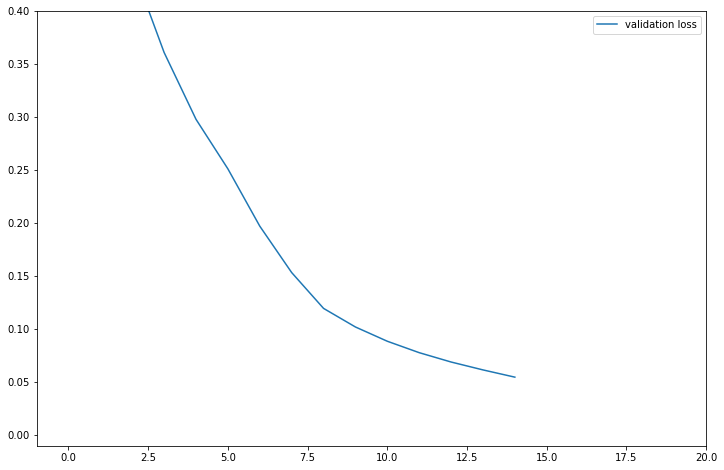

In [11]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['val_loss'], label='validation loss')

plt.xlim(-1,20)
plt.ylim(-0.01, 0.4)

plt.legend(), plt.grid
plt.show()

### 모델 평가

In [12]:
model = load_model('./Models/model.h5')

Y_pred = model.predict(X_test)
Y_pred

array([[0.00472639, 0.04103048, 0.01699685, 0.93724626],
       [0.01073819, 0.07215381, 0.01644081, 0.9006672 ],
       [0.9627197 , 0.01659053, 0.00941502, 0.01127474],
       ...,
       [0.00943672, 0.00364508, 0.9656736 , 0.02124459],
       [0.9624575 , 0.01674725, 0.00945481, 0.0113405 ],
       [0.00524689, 0.93501365, 0.00754049, 0.05219896]], dtype=float32)

In [13]:
multilabel_confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

array([[[411,   0],
        [  0, 129]],

       [[411,   0],
        [  0, 129]],

       [[404,   0],
        [  0, 136]],

       [[394,   0],
        [  0, 146]]], dtype=int64)